# Reconociendo caracteres con Python. 
*y otras yerbas...*








**Ariel Rossanigo**

### Objetivos de la charla

* Mostrar algunas librerias copadas 
* Hablar de *Machine learning* (es un tema que me gusta)
* Ver como en pocas lineas de codigo hacemos un OCR de números


In [ ]:
from example import process_image
process_image()

### ¿Cómo logramos esto?

In [ ]:
# %load example.py
from utils import make_animation
from image_processing import get_image
import matplotlib.pylab as plt

def get_digits_fake(img):
    h, w = img.shape
    for c in range(h//28):
        for r in range(w//28):
            s = (slice(28*c, 28*(c+1), None), slice(28*r, 28*(r+1), None))
            digit = img[s]
            yield digit, s

def process_image():
    numbers = list(map(int, open('numbers.txt').read().split(' ')))
    o, _ = get_image('numbers.png')
    slices = [(s, 'green', n) for ((_, s), n) in zip(get_digits_fake(o), numbers)]
    ani = make_animation(o, slices, 300)
    plt.show()


Si... es broma... 


### ¿Cómo logramos esto?

* Por un lado, hay que reconocer las distintas partes de la imagen
* Por otro lado, tenemos que programar una función que relacione pixeles con números

## OpenCV

* Open Source Computer Vision Library
* Computer Vision + Machine Learning
* más de 2500 algoritmos optimizados, escritos en **C++**

* pero tiene interfaz para **Python**
* también se puede usar en C, Java y MATLAB
* corre en Windows, Linux, Android y Mac

### Abriendo una imagen y aplicándo filtros.

In [ ]:
%matplotlib inline

import cv2
import numpy as np
from utils import show_images


img = cv2.imread('numbers.png', False)

original = img.copy()
blur = cv2.GaussianBlur(img, (15, 15), 0)
thresh = cv2.adaptiveThreshold(blur, 255, adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
                               thresholdType=cv2.THRESH_BINARY, blockSize=3, C=1)


In [ ]:
show_images([original])

In [ ]:
show_images([blur])

In [ ]:
show_images([thresh])

### Buscando renglones y characteres

* Tenemos una función que nos  deja buscar contornos...

In [ ]:
chiquita = 255 - original[0:56, 0:56]
nueva, contornos, _ = cv2.findContours(chiquita.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
show_images([chiquita, nueva], columns=2)

* Tenemos otra función que nos deja encerrar un contorno con un rectángulo

In [ ]:
for contorno in contornos:
    p = cv2.boundingRect(contorno)
    print("x: {:3d} y: {:3d} w: {:3d} h: {:3d}".format(*p))

### ¿Cómo podemos hacer para encontrar solo un renglón?

In [ ]:
h, w = chiquita.shape

lineas = cv2.morphologyEx(255 - chiquita, cv2.MORPH_OPEN,  np.ones((1, w)))
nueva, contornos, _ = cv2.findContours(255-lineas.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

show_images([chiquita, lineas, nueva], columns=3)
for contorno in contornos:
    p = cv2.boundingRect(contorno)
    print("x: {:3d} y: {:3d} w: {:3d} h: {:3d}".format(*p))

In [ ]:
contorno = contornos[0]
xr, yr, wr, hr = cv2.boundingRect(contorno)
renglon = cv2.morphologyEx(255 - chiquita[yr:yr+hr, xr:xr+wr], cv2.MORPH_OPEN,  np.ones((7, 10)))
nueva, contornos, _ = cv2.findContours(255-renglon.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
show_images([chiquita, renglon, nueva], columns=3)
print (len(contornos))

In [ ]:
caracteres = []
for contorno in contornos:
    x, y, w, h = cv2.boundingRect(contorno)
    if w > 5 and h > 15:
        caracteres.append(255 - chiquita[y+yr:y+yr+h, x:x+w])
    
show_images(caracteres)

### Terminando...

* queremos imagenes de 28x28

In [ ]:
from image_processing import centered_slice

caracter = caracteres[1]
h, w = caracter.shape
m = max(h, w)
quad = np.ones((m, m), dtype=np.uint8) * 255
quad[centered_slice(h, m), centered_slice(w, m)] = caracter

caracter_final = cv2.resize(quad, (28, 28))

show_images([caracter, caracter_final])



In [ ]:
%matplotlib tk
from utils import make_animation
from image_processing import get_image, get_lines, get_chars, process_char
import matplotlib.pylab as plt

def get_digits(img):
    for line_slice in get_lines(img):
        for char_slice in get_chars(img, line_slice):
            digit = process_char(img, char_slice)
            yield digit, char_slice

#def get_digits_fake(img):
#    h, w = img.shape
#    for c in range(h//28):
#        for r in range(w//28):
#            s = (slice(28*c, 28*(c+1), None), slice(28*r, 28*(r+1), None))
#            digit = img[s]
#            yield digit, s

numbers = list(map(int, open('numbers.txt').read().split(' ')))
o, f = get_image('numbers.png')
slices = [(s, 'green', n) for ((_, s), n) in zip(get_digits(f), numbers)]
ani = make_animation(o, slices, 300)
plt.show()

### Ahora si... queda solo una función para que ande el OCR

&lt;optimistic mode&gt;

   *Es simple! solo hay que hacer que pueda mapear una imagen de 28x28 pixeles a un dígito*

&lt;/optimistic mode&gt;

* Vamos a usar aprendizaje supervisado, entonces... Necesitamos muchas imagenes clasificadas...

### MNIST

* Base de datos con 2 datasets
* Todas las imagenes están pre-procesadas
* Es como un standar para probar distintos algoritmos de entrenamiento
* Se pueden descargar en formato binario o csv


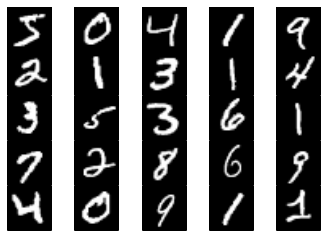

In [4]:
%matplotlib inline

import numpy as np
from utils import show_images

no_images = 25

with open('train-images-idx3-ubyte', 'rb') as f:
    f.read(16)
    X = np.array(list(f.read(28 * 28 * no_images)), dtype=np.uint8)
    X = X.reshape(no_images, 28 * 28)

show_images(X, new_shape=(28, 28))


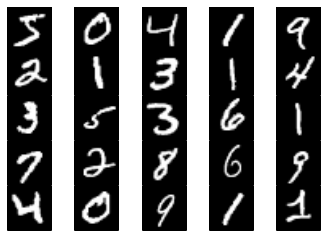

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1]


In [6]:
with open('train-labels-idx1-ubyte', 'rb') as f:
    f.read(8)
    y = np.array(list(f.read(no_images)))
    
show_images(X, new_shape=(28, 28))
print(y)

## sklearn

* Machine learning en Python
* Hecho sobre Numpy, SciPy y MatPlotLib
* Contiene de todo un poco...
* Nos interesa:
    + Armar un clasificador 
    + Medir que tan bien funciona el clasificador


### Regresión logistica

* Es una regresión lineal con una función logística en su salida
* El modelo es una recta, hay que aprender los parámetros
* La salida nos dice que probabilidad hay de que la entrada sea de **Positiva**
* ¿que pasa si hay varias clases?

**En sklearn tenemos todo resuelto en SGDClassifier**

In [8]:
from digits_classifiers import get_datasets
from sklearn.linear_model import SGDClassifier

X_train, y_train, X_val, y_val = get_datasets()

classifier = SGDClassifier(loss='log')
classifier.fit(X_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

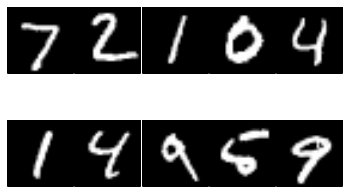

[7 2 1 0 4 1 4 9 6 9]


In [13]:
from utils import show_images

a_predecir = X_val[:10]
predicciones = classifier.predict(a_predecir)

show_images(a_predecir, new_shape=(28, 28), columns=5)
print(predicciones)

### Midiendo que tan bien funciona

* Vamos a usar **accuracy**: porcentaje de veces que predice bien

In [14]:
from sklearn.metrics import accuracy_score

predictions = classifier.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print("Accuracy: {}%".format(accuracy*100))

Accuracy: 87.63%


## Ponemos todo junto...

In [18]:
%matplotlib tk

from image_processing import get_digits, get_image 
from utils import make_animation
import matplotlib.pylab as plt

original, img = get_image('numbers.png')

predictions = []
for digit, slice_ in get_digits(img):
    p = classifier.predict(digit)[0]
    predictions.append((slice_, 'green', p))

ani = make_animation(original, predictions, interval=300)
plt.show()

# Gracias! ¿Preguntas?

Si me quieren contactar:

* arielrossanigo@gmail.com
* @arielrossanigo
* https://github.com/arielrossanigo

# Enlaces

* [OpenCV (opencv.org)](http://opencv.org/)
* [MNIST (yann.lecun.com/exdb/mnist)](http://yann.lecun.com/exdb/mnist/)
* [scikit-learn (scikit-learn.org)](http://scikit-learn.org/)